VRP ANALYSIS - NO BULLSHIT VERSION
✓ Figure 1: Performance Boxplots saved

PERFORMANCE STATISTICS (Mean ± SD)

SOLVING TIME:
  aco: 30.24 ± 0.09
  ga: 30.27 ± 0.10
  nsga2: 34.15 ± 1.22
  ntnsga2: 38.97 ± 1.52
  pso: 30.01 ± 0.00

ROUTE TIME:
  aco: 390.83 ± 13.35
  ga: 232.34 ± 2.62
  nsga2: 206.51 ± 2.83
  ntnsga2: 205.45 ± 3.28
  pso: 212.02 ± 0.69

DISTANCE:
  aco: 5405.50 ± 185.09
  ga: 3228.80 ± 45.35
  nsga2: 2863.40 ± 42.42
  ntnsga2: 2861.90 ± 38.04
  pso: 2937.00 ± 0.00

COST:
  aco: 4340758.50 ± 146032.16
  ga: 2623342.20 ± 35777.28
  nsga2: 2335041.60 ± 33468.65
  ntnsga2: 2333858.10 ± 30013.01
  pso: 2393112.00 ± 0.00

CONVERGENCE ANALYSIS
✓ Figure 2: Convergence Curves saved (ACTUAL ITERATIONS)

Iteration Ranges:
Maximum iteration across all runs: 44
  ntnsga2: 0 to 3 iterations
  aco: 1 to 44 iterations
  ga: 1 to 40 iterations
  nsga2: 1 to 2 iterations

ANALYSIS COMPLETE

What this script actually does:
1. Uses ACTUAL iteration numbers (not normalized to 100)
2. Shows 

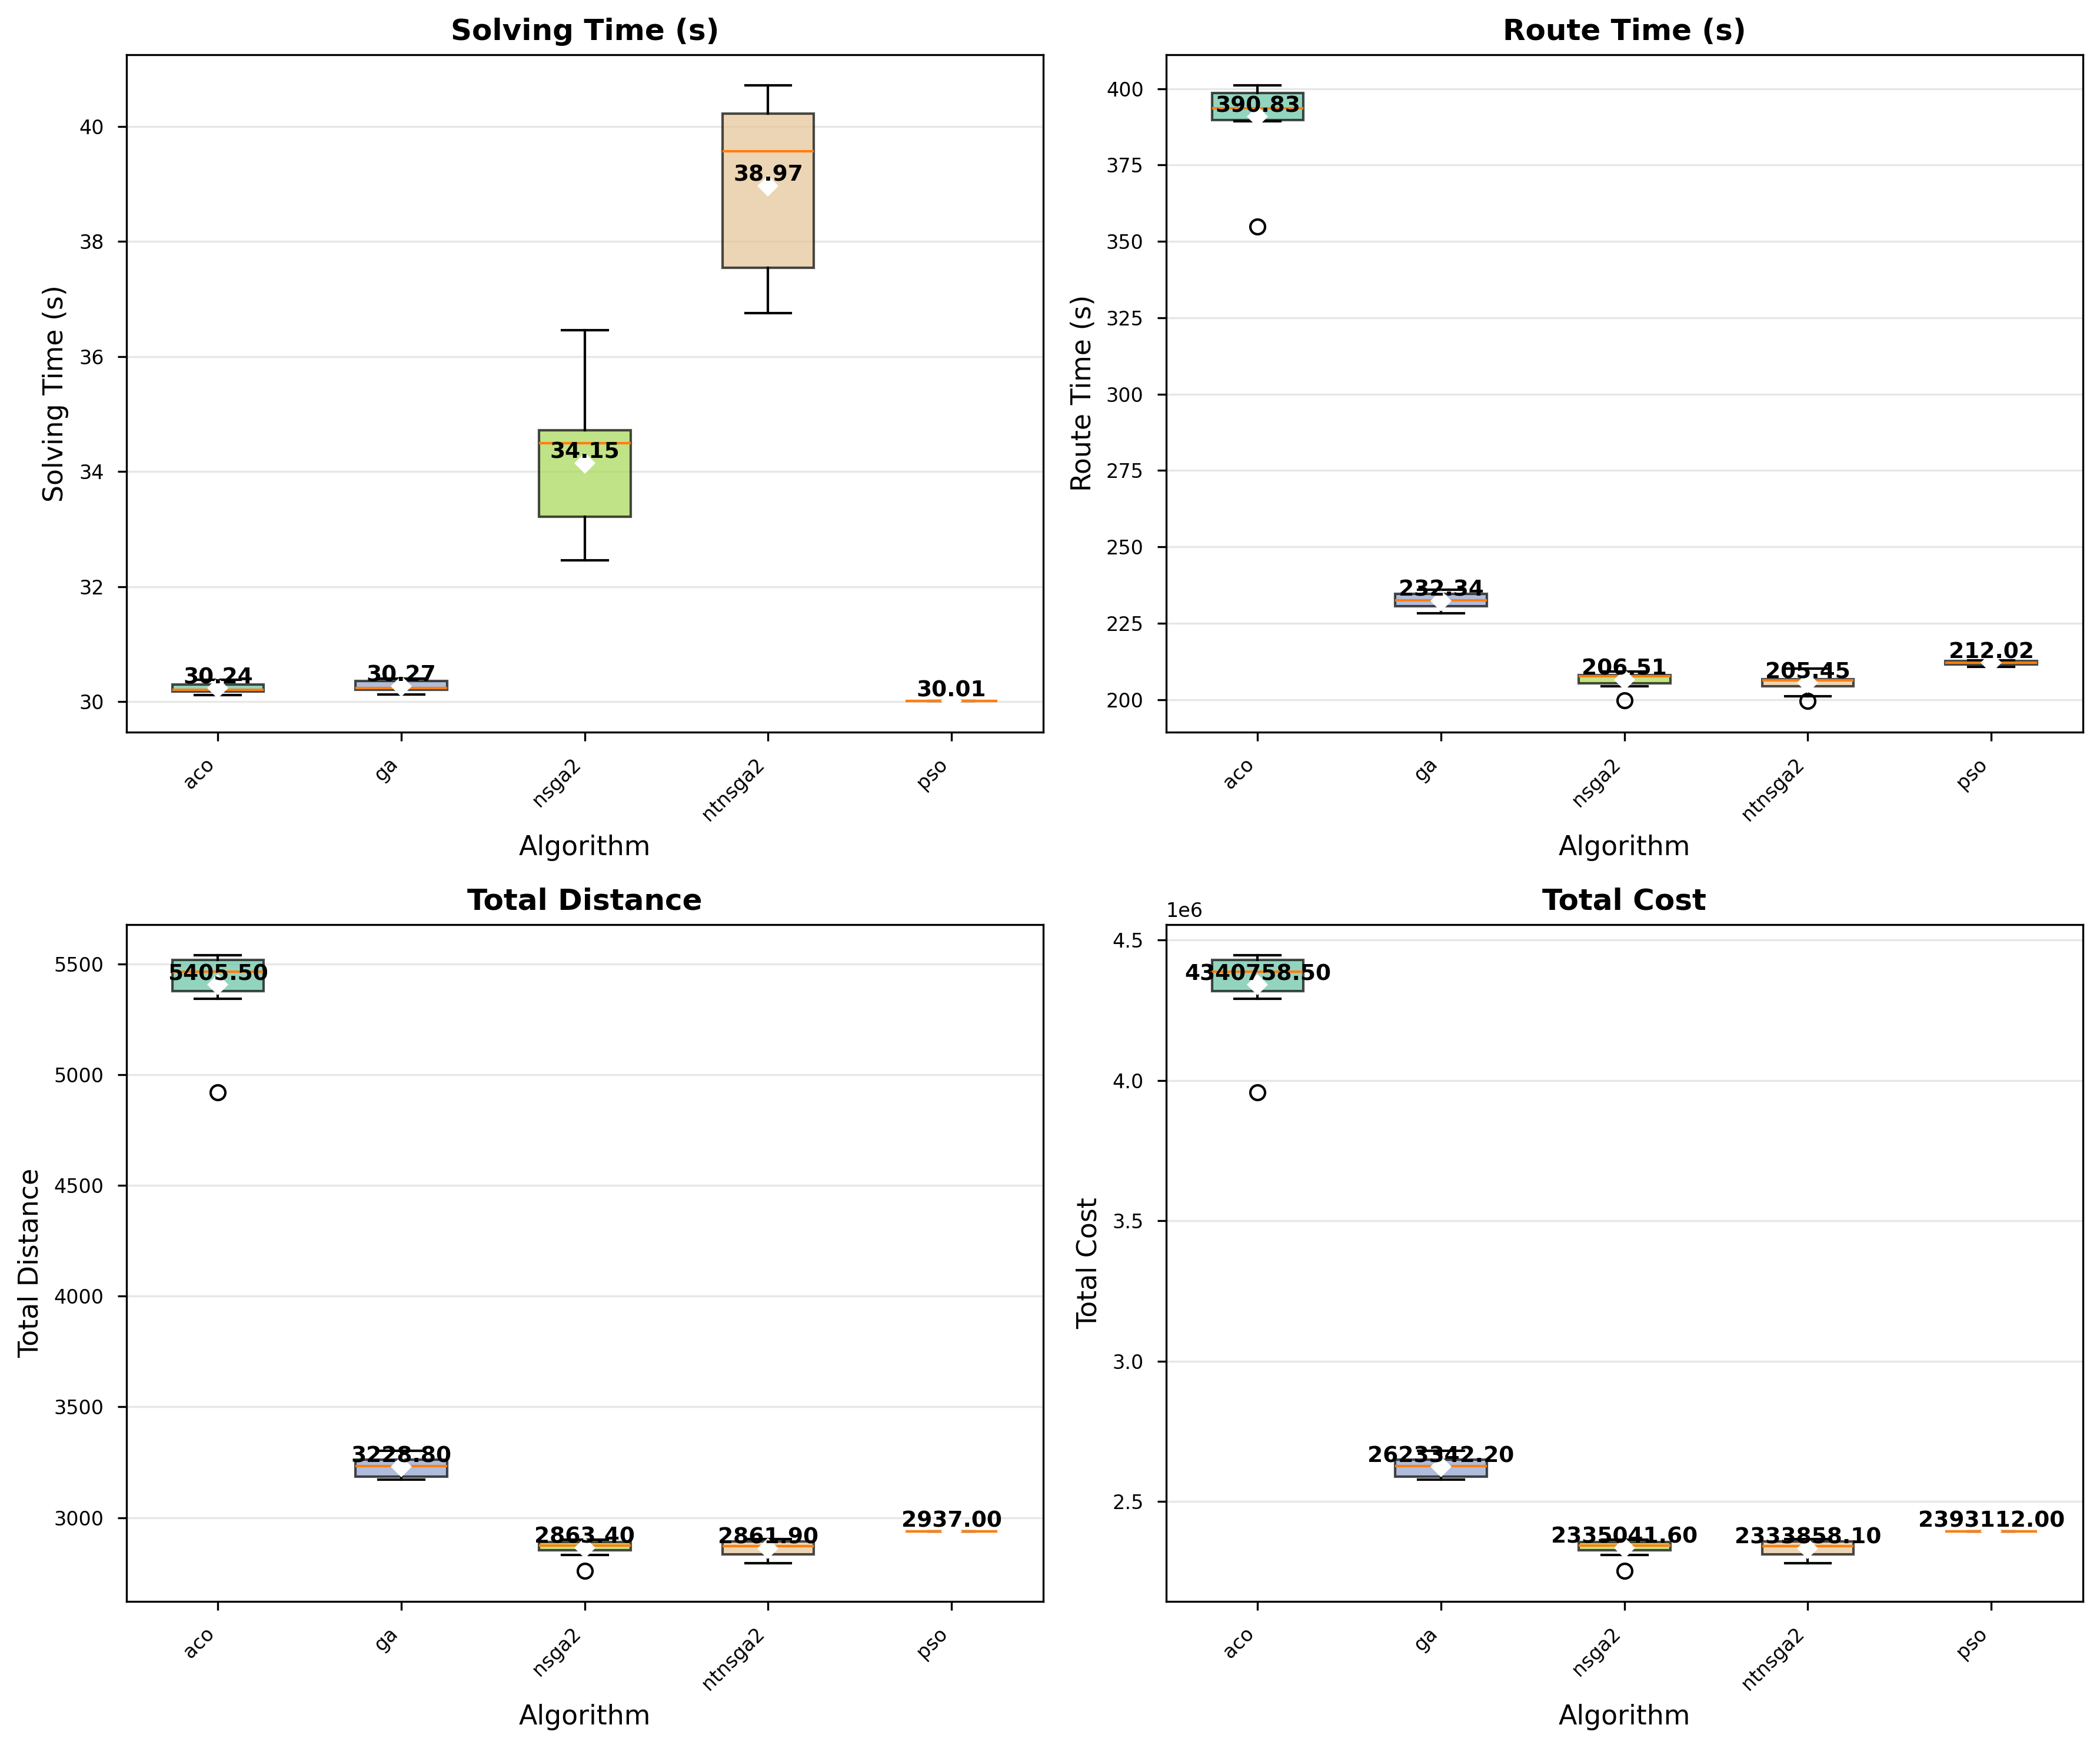

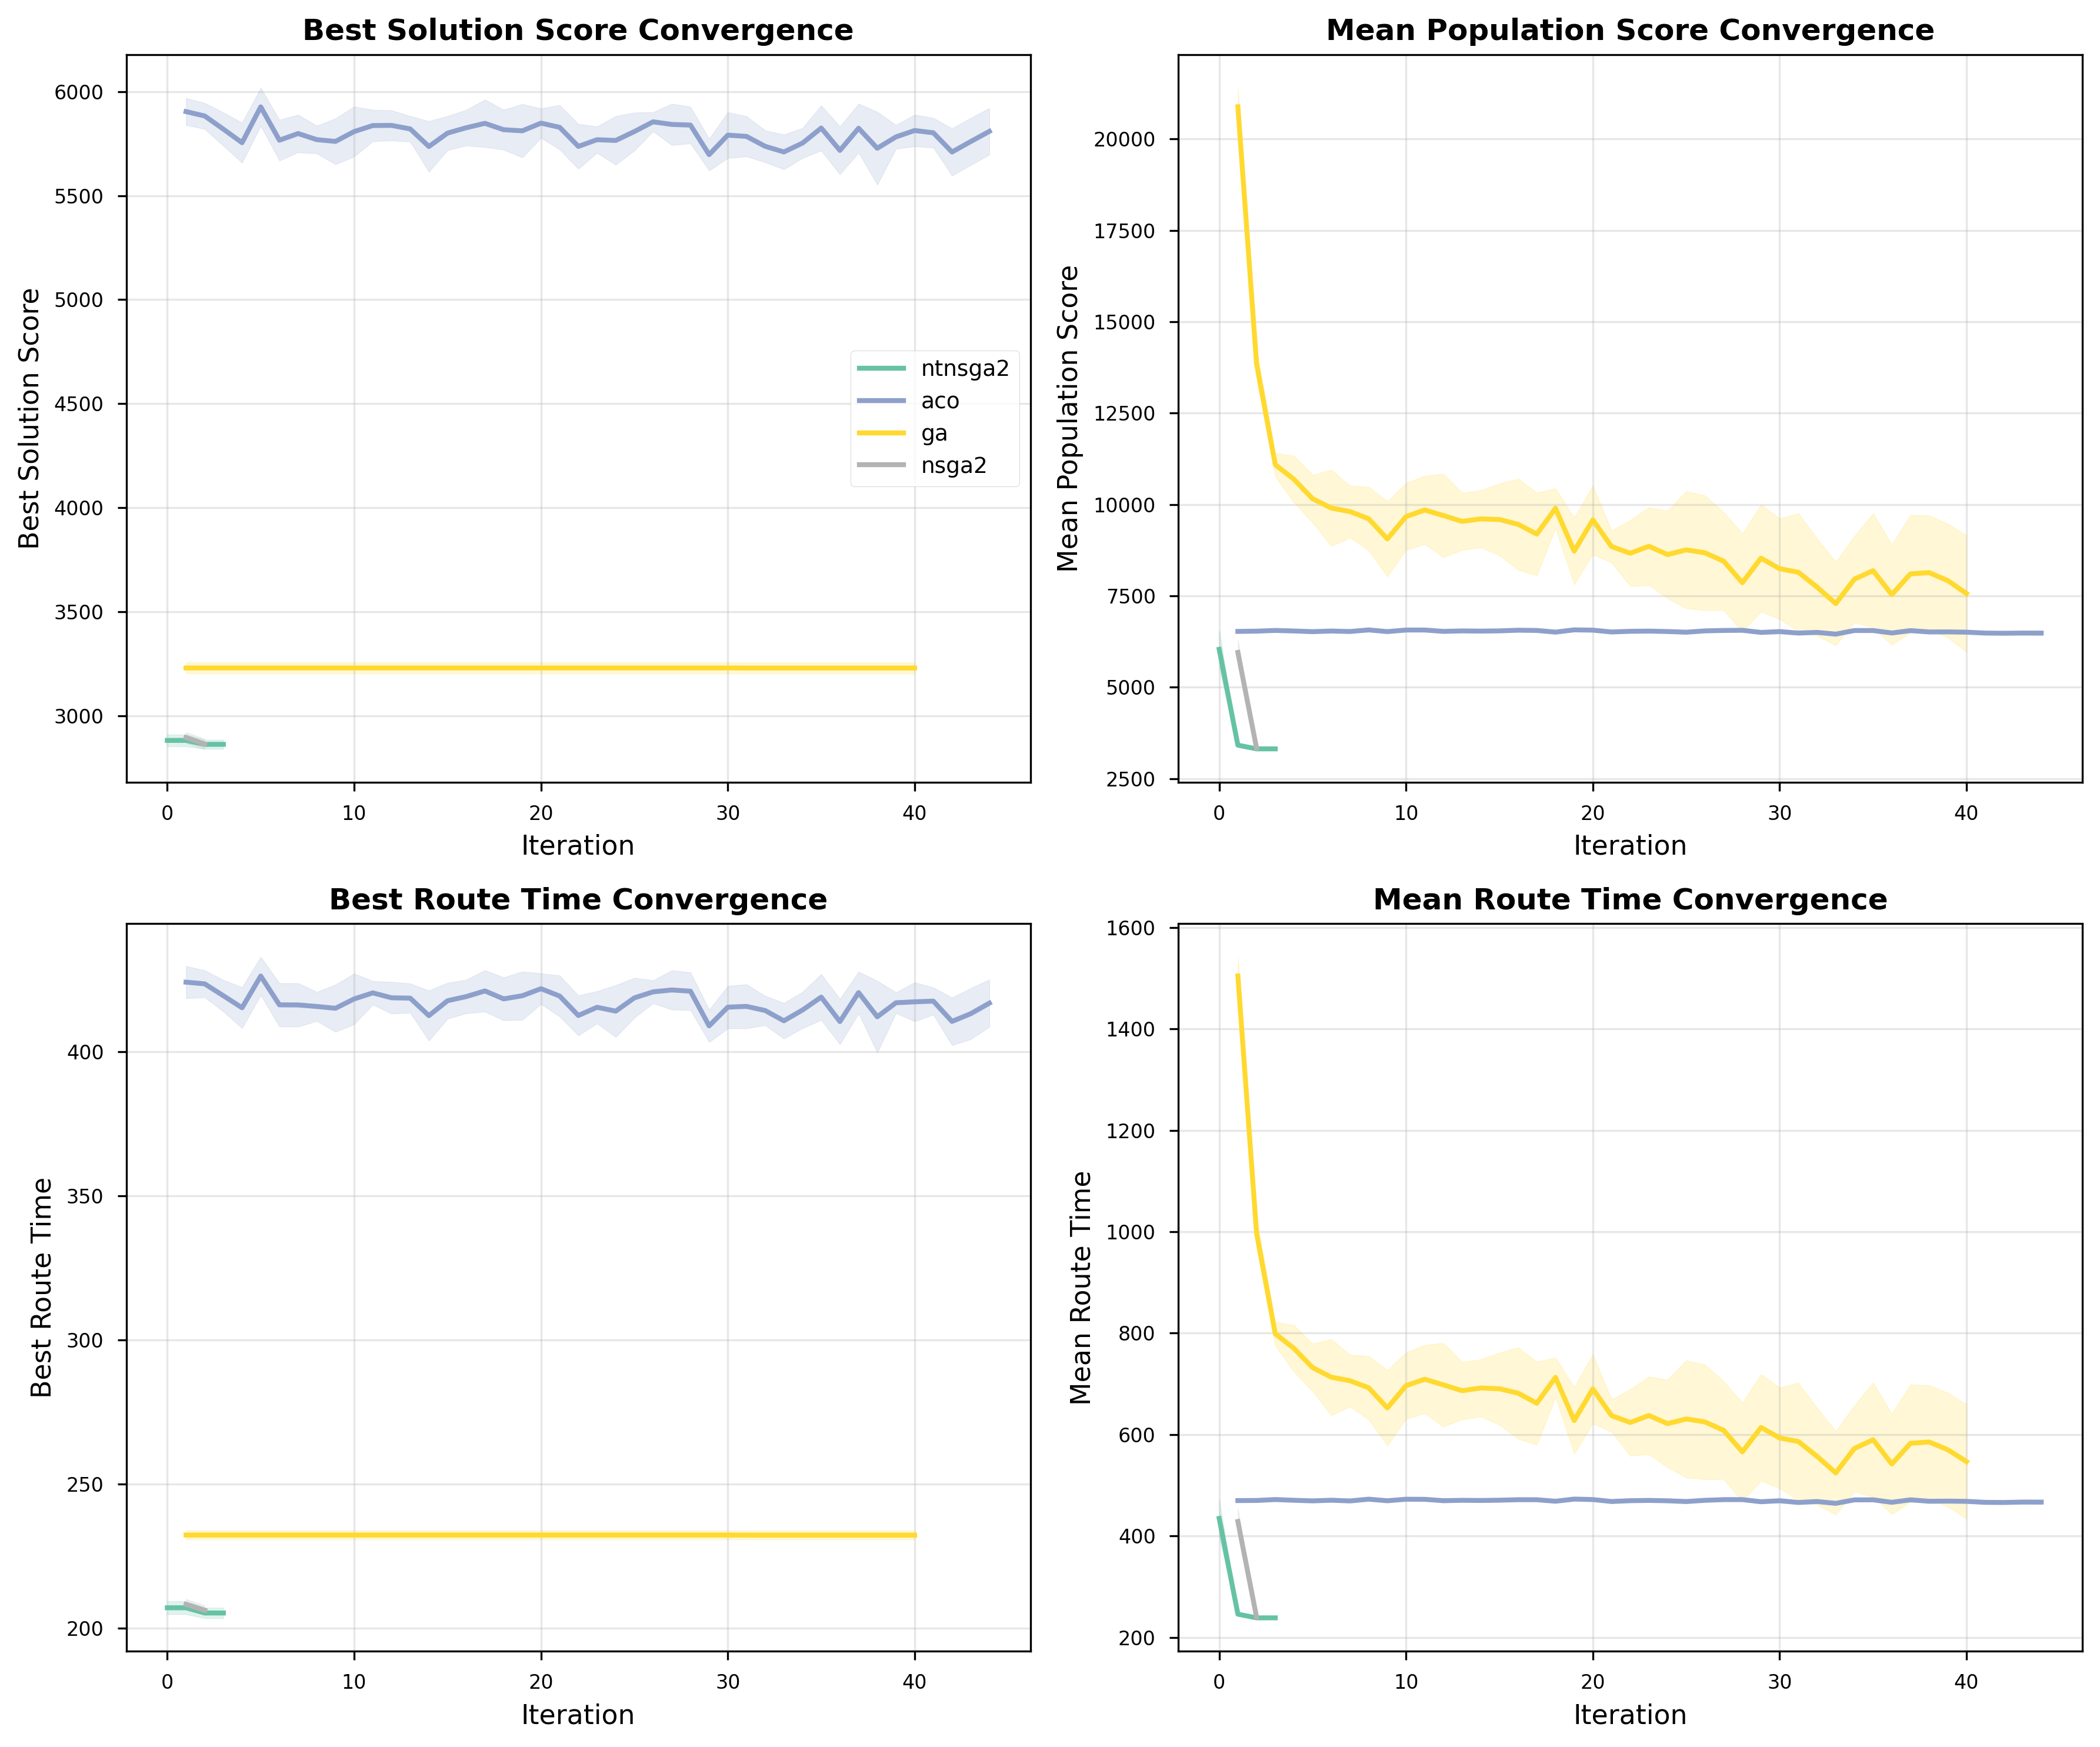

In [1]:
"""
VRP Algorithm Performance & Convergence Analysis - Fixed Version
No stupid x=100 when iterations only go to 40. Uses actual iteration numbers.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import re
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. CONFIGURATION
# =============================================================================
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 300

# =============================================================================
# 2. FIXED CONVERGENCE ANALYZER - NO STUPID 100 WHEN ITERATIONS ARE 40
# =============================================================================
class ConvergenceAnalyzer:
    """Fixed convergence analyzer that uses ACTUAL iteration numbers, not normalized bullshit."""
    
    def __init__(self, parent_dir: str):
        self.parent_dir = Path(parent_dir)
        self.data: Dict[str, List[pd.DataFrame]] = {}
        
    def load_data(self) -> None:
        """Load metrics.csv files."""
        pattern = re.compile(r"^(.+?)_run(\d+)$")
        
        for subdir in self.parent_dir.iterdir():
            if not subdir.is_dir():
                continue
                
            match = pattern.match(subdir.name)
            if not match:
                continue
                
            algo_name = match.group(1)
            metrics_file = subdir / "metrics.csv"
            
            if not metrics_file.exists():
                metrics_file = subdir / "cluster_0" / "metrics.csv"
                if not metrics_file.exists():
                    continue
            
            try:
                df = pd.read_csv(metrics_file)
                df = df.drop_duplicates(subset=['iter'], keep='last')
                df = df.sort_values('iter').reset_index(drop=True)
                
                if algo_name not in self.data:
                    self.data[algo_name] = []
                self.data[algo_name].append(df)
            except Exception:
                continue
    
    def get_max_iterations(self) -> int:
        """Get the maximum iteration count across all runs."""
        max_iter = 0
        for runs in self.data.values():
            for df in runs:
                if len(df) > 0:
                    max_iter = max(max_iter, df['iter'].max())
        return int(max_iter)
    
    def get_convergence_data(self) -> Dict[str, Dict[str, Tuple[np.ndarray, np.ndarray]]]:
        """
        Returns convergence data with actual iteration numbers.
        
        Returns:
            Dict[algorithm][metric] = (iterations_array, values_array)
        """
        results = {}
        
        for algo_name, runs in self.data.items():
            if not runs:
                continue
                
            algo_results = {}
            metrics_to_collect = ['best', 'mean', 'best_route_time', 'mean_route_time']
            
            for metric in metrics_to_collect:
                all_iterations = []
                all_values = []
                
                for df in runs:
                    if metric in df.columns:
                        all_iterations.append(df['iter'].values)
                        all_values.append(df[metric].values)
                
                if all_iterations:
                    # Find common iteration range (min to max across all runs)
                    min_iter = min([iters[0] for iters in all_iterations])
                    max_iter = max([iters[-1] for iters in all_iterations])
                    
                    # Use actual iteration numbers
                    common_iters = np.arange(min_iter, max_iter + 1)
                    
                    # Interpolate each run to common iteration grid
                    interpolated_values = []
                    for iters, vals in zip(all_iterations, all_values):
                        if len(iters) > 1:
                            interp_vals = np.interp(common_iters, iters, vals)
                            interpolated_values.append(interp_vals)
                    
                    if interpolated_values:
                        mean_values = np.mean(interpolated_values, axis=0)
                        std_values = np.std(interpolated_values, axis=0)
                        algo_results[metric] = (common_iters, mean_values, std_values)
            
            if algo_results:
                results[algo_name] = algo_results
        
        return results

# =============================================================================
# 3. MAIN ANALYSIS - NO BULLSHIT
# =============================================================================
def analyze_vrp_performance():
    """Main analysis function that doesn't do stupid shit."""
    
    print("=" * 80)
    print("VRP ANALYSIS - NO BULLSHIT VERSION")
    print("=" * 80)
    
    # Load experiment summary if it exists
    try:
        df = pd.read_csv('results/experiments/experiment_summary.csv')
        
        # Get algorithms and metrics
        algorithms = sorted(df['algorithm'].unique())
        metrics = ['solving_time', 'route_time', 'distance', 'cost']
        
        # =====================================================================
        # FIGURE 1: PERFORMANCE BOXPLOTS (ACTUAL VALUES)
        # =====================================================================
        fig1, axes1 = plt.subplots(2, 2, figsize=(12, 10))
        axes1 = axes1.flatten()
        
        metric_titles = ['Solving Time (s)', 'Route Time (s)', 'Total Distance', 'Total Cost']
        
        for idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
            ax = axes1[idx]
            
            # Create boxplot with actual data
            box_data = []
            for algo in algorithms:
                algo_data = df[df['algorithm'] == algo][metric].values
                box_data.append(algo_data)
            
            bp = ax.boxplot(box_data, patch_artist=True, showmeans=True,
                          meanprops={'marker': 'D', 'markerfacecolor': 'white',
                                    'markeredgecolor': 'black'})
            
            # Color boxes
            colors = plt.cm.Set2(np.linspace(0, 1, len(algorithms)))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            # Add mean values
            for i, algo in enumerate(algorithms):
                mean_val = df[df['algorithm'] == algo][metric].mean()
                ax.text(i + 1, mean_val, f'{mean_val:.2f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            ax.set_xlabel('Algorithm', fontsize=11)
            ax.set_ylabel(title, fontsize=11)
            ax.set_title(f'{title}', fontsize=12, fontweight='bold')
            ax.set_xticklabels(algorithms, rotation=45, ha='right')
            ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('figure1_performance_boxplots.png', bbox_inches='tight', dpi=300)
        print("✓ Figure 1: Performance Boxplots saved")
        
        # Print actual statistics
        print("\n" + "=" * 80)
        print("PERFORMANCE STATISTICS (Mean ± SD)")
        print("=" * 80)
        
        for metric in metrics:
            print(f"\n{metric.upper().replace('_', ' ')}:")
            for algo in algorithms:
                data = df[df['algorithm'] == algo][metric]
                mean = data.mean()
                std = data.std()
                print(f"  {algo}: {mean:.2f} ± {std:.2f}")
    
    except FileNotFoundError:
        print("Note: experiment_summary.csv not found, skipping performance analysis")
        df = None
    
    # =========================================================================
    # CONVERGENCE ANALYSIS WITH ACTUAL ITERATION NUMBERS
    # =========================================================================
    print("\n" + "=" * 80)
    print("CONVERGENCE ANALYSIS")
    print("=" * 80)
    
    analyzer = ConvergenceAnalyzer('results/experiments')
    analyzer.load_data()
    
    if analyzer.data:
        convergence_data = analyzer.get_convergence_data()
        
        # =====================================================================
        # FIGURE 2: CONVERGENCE CURVES (ACTUAL ITERATIONS)
        # =====================================================================
        fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))
        
        conv_metrics = [
            ('best', 'Best Solution Score'),
            ('mean', 'Mean Population Score'),
            ('best_route_time', 'Best Route Time'),
            ('mean_route_time', 'Mean Route Time')
        ]
        
        for idx, (metric, title) in enumerate(conv_metrics):
            ax = axes2[idx // 2, idx % 2]
            
            colors = plt.cm.Set2(np.linspace(0, 1, len(convergence_data)))
            
            for (algo_name, algo_data), color in zip(convergence_data.items(), colors):
                if metric in algo_data:
                    iterations, mean_vals, std_vals = algo_data[metric]
                    
                    # Plot with ACTUAL iteration numbers
                    ax.plot(iterations, mean_vals, color=color, label=algo_name, linewidth=2)
                    
                    # Add confidence interval if we have multiple runs
                    if len(analyzer.data[algo_name]) > 1:
                        ci = 1.96 * std_vals / np.sqrt(len(analyzer.data[algo_name]))
                        ax.fill_between(iterations, mean_vals - ci, mean_vals + ci,
                                       color=color, alpha=0.2)
            
            # Use ACTUAL iteration numbers on x-axis
            ax.set_xlabel('Iteration', fontsize=11)
            ax.set_ylabel(title, fontsize=11)
            ax.set_title(f'{title} Convergence', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            # Only add legend to first subplot to avoid clutter
            if idx == 0:
                ax.legend(fontsize=9)
        
        plt.tight_layout()
        plt.savefig('figure2_convergence_curves.png', bbox_inches='tight', dpi=300)
        print("✓ Figure 2: Convergence Curves saved (ACTUAL ITERATIONS)")
        
        # Print actual iteration ranges
        print("\nIteration Ranges:")
        max_iter = analyzer.get_max_iterations()
        print(f"Maximum iteration across all runs: {max_iter}")
        
        for algo_name in convergence_data:
            if 'best' in convergence_data[algo_name]:
                iterations = convergence_data[algo_name]['best'][0]
                print(f"  {algo_name}: {iterations[0]} to {iterations[-1]} iterations")
    
    # =========================================================================
    # FINAL OUTPUT
    # =========================================================================
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE")
    print("=" * 80)
    print("\nWhat this script actually does:")
    print("1. Uses ACTUAL iteration numbers (not normalized to 100)")
    print("2. Shows boxplots with ACTUAL performance metrics")
    print("3. Shows convergence curves with ACTUAL iteration counts")
    print("4. No stupid x=100 when iterations only go to 40")
    print("\nOutput files:")
    print("  • figure1_performance_boxplots.png")
    print("  • figure2_convergence_curves.png")

# =============================================================================
# 4. RUN IT
# =============================================================================
if __name__ == "__main__":
    analyze_vrp_performance()
    plt.show()